In [1]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from packaging import version

BENCHMARK = 'pmem2bench'

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:3.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

FIG_DIR = Path(f'../fig/{BENCHMARK}').resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    for ext in ('png', 'eps'):
        fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    pass 

In [2]:
RAW_BASEDIR=Path("../raw/")

default_params = {
    "noflush": False,
}

job_group = (
    ("pegasus/pmem2bench/2023.06.22-18.16.11", {"platform": "pegasus", "loadApi": "libc"}),
    ("pegasus/pmem2bench/2023.06.22-19.16.25", {"platform": "pegasus", "loadApi": "libc"}),
    ("pegasus/pmem2bench/2023.06.23-12.22.20", {"platform": "pegasus", "loadApi": "libc"}),
    # ("cygnus/pmem2bench/2023.06.23-14.34.22", {"platform": "cygnus", "loadApi": "libc"}),
    ("chris90/pmem2bench/2023.06.23-18.02.15", {"platform": "chris90", "loadApi": "libc"}),
    ("chris80/pmem2bench/2023.06.30-15.23.45", {"platform": "chris80", "loadApi": "libc"}),
    ("chris90/pmem2bench/2023.07.02-13.56.01", {"platform": "chris90", "loadApi": "libpmem2"}),
    ("chris80/pmem2bench/2023.07.02-13.55.20", {"platform": "chris80", "loadApi": "libpmem2"}),
    ("pegasus/pmem2bench/2023.07.02-18.03.12", {"platform": "pegasus", "loadApi": "libpmem2"}),
    ("pegasus/pmem2bench/2023.07.03-10.40.39", {"platform": "pegasus", "loadApi": "libpmem2"}),
    ('chris80/pmem2bench/2023.07.03-11.08.54', {"platform": "chris80", "loadApi": "libpmem2"}),
    ('chris90/pmem2bench/2023.07.03-11.07.22', {"platform": "chris90", "loadApi": "libpmem2"}),
)

def parse_result(json_file: Path):
    with json_file.open() as f:
        return json.load(f)


re_iter = re.compile(r"_([0-9]+)\.json")
def parse_iter_from_filename(json_file: Path):
    m = re_iter.search(json_file.name)
    if m:
        return int(m.groups()[0])
    else:
        raise Exception("parse error: iteration")

failed_job_count = 0
job_params = []
job_results = []
for job_dir, meta_overwrite in job_group:
    job_dir = RAW_BASEDIR / job_dir
    for job_file in job_dir.glob("*.json"):
        try:
            parsed = parse_result(job_file)
            job_params.append({
                **default_params,
                **parsed["params"],
                "iter": parse_iter_from_filename(job_file),
                **meta_overwrite,
            })
            job_results.append(parsed["results"])
        except Exception as e:
            print(f"{job_file}: {e}")
            failed_job_count += 1
print(f"failed: {failed_job_count}")

df_params = pd.DataFrame(job_params)

df_params["device"] = np.select([
    (df_params.platform == "pegasus"),
    (df_params.platform == "chris90"),
    (df_params.platform.isin(["cygnus", "chris80"])),
], [
    "Optane 300",
    "Optane 200",
    "Optane 100",
])

df_params["api"] = np.select([
    (df_params.accessType == "write"),
    (df_params.accessType == "read") & (df_params.loadApi == "libc"),
    (df_params.accessType == "read") & (df_params.loadApi == "libpmem2"),
], [
    "libpmem2",
    "libc",
    "libpmem2",
])

# If loadApi is libc, it is not actually using a non-temporal store
df_params.loc[(df_params.api == "libc"), "nonTemporal"] = False
df_params.loc[(df_params.api == "libc"), "noflush"] = True

df_results = pd.DataFrame(job_results)
df_src = df_params.join(df_results)

failed: 0


In [3]:
# df_src.drop(["path"],axis=1).query("success == True and platform=='chris80'")

df_src.query("api == 'libc' and noflush == True")

,noflush,accessPattern,accessType,blockSize,granularity,nonTemporal,nthreads,path,set-affinity,source,...,loadApi,device,api,IOPS,MIOPS,MiB_per_sec,addr,byte_per_sec,success,time
1,True,sequential,read,128,page,False,4,/dev/dax0.0,True,anon,...,libc,Optane 300,libc,5.278782e+07,52.787820,6443.825730,22772990345216,6.756841e+09,True,5085.177870
4,True,random,read,2048,page,False,1,/dev/dax0.0,True,devdax,...,libc,Optane 300,libc,1.390240e+06,1.390240,2715.312697,21205327282176,2.847212e+09,True,3016.963759
6,True,sequential,read,65536,page,False,1,/dev/dax0.0,True,devdax,...,libc,Optane 300,libc,6.965542e+04,0.069655,4353.463716,21232170827776,4.564938e+09,True,1881.720059
8,True,sequential,read,524288,page,False,32,/dev/dax0.0,True,devdax,...,libc,Optane 300,libc,1.547155e+05,0.154716,77357.751564,20984136466432,8.111548e+10,True,3388.723104
13,True,random,read,512,page,False,8,/dev/dax0.0,True,devdax,...,libc,Optane 300,libc,3.148831e+07,31.488312,15375.152374,20383914786816,1.612202e+10,True,4262.461822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8048,True,sequential,read,524288,page,False,2,/dev/dax0.1,True,devdax,...,libc,Optane 100,libc,1.055767e+04,0.010558,5278.833889,140101833195520,5.535259e+09,True,3103.715772
8050,True,sequential,read,131072,page,False,4,/dev/dax0.1,True,devdax,...,libc,Optane 100,libc,7.451328e+04,0.074513,9314.160027,140047072362496,9.766605e+09,True,3518.084283
8052,True,random,read,1048576,page,False,2,/dev/dax0.1,True,devdax,...,libc,Optane 100,libc,5.134049e+03,0.005134,5134.048514,139662672789504,5.383440e+09,True,3191.243705
8056,True,random,read,256,page,False,2,/dev/dax0.1,True,devdax,...,libc,Optane 100,libc,1.088636e+07,10.886361,2657.803081,140111496871936,2.786909e+09,True,6164.489807


In [4]:
df = df_src

# remove fsdax && iter=1 && write
# df = df.drop(df[(df.source == "fsdax") & (df.accessType == "write") & (df.iter == 1)].index)

default_groupby = ["success", "platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush", "nthreads", "blockSize"]
grouper = df.drop(["path", "granularity", "set-affinity"], axis=1).groupby(default_groupby)

pd.set_option('display.max_rows', 50)
iters = grouper.size()
iters[iters < 3]


success  platform  source  accessType  api       accessPattern  nonTemporal  noflush  nthreads  blockSize
True     pegasus   anon    write       libpmem2  random         False        False    16        256          1
                                                                                                512          2
dtype: int64

In [5]:
# calc parallel performance
# pegasus devdax sequential nt-strore / load

df = grouper.max().reset_index().query("platform == 'pegasus' and source == 'devdax' and api == 'libpmem2' and accessPattern == 'sequential' and nonTemporal == True")
df["GiB/s"] = df["byte_per_sec"] / 2**30

# df_marged = df.join(df.query("nthreads==1")[["accessType", "blockSize", "GiB/s"]], how=["accessType", "BlockSize"])

df_merged = pd.merge(
    df,
    df.query("nthreads==1")[["accessType", "blockSize", "GiB/s"]].rename(columns={"GiB/s": "base"}),
    how='left', left_on=['accessType','blockSize'], right_on = ['accessType','blockSize'])

df_merged["speedup"] = df_merged["GiB/s"] / df_merged["base"]
df_merged["parallel_perf"] = df_merged["speedup"] / df_merged["nthreads"]

df_merged = df_merged[["accessType", "nthreads", "blockSize", "GiB/s", "speedup", "parallel_perf"]]

pd.set_option('display.max_rows', 250)

display(df_merged[(df_merged.blockSize == 64)])

pd.set_option('display.max_rows', 50)


,accessType,nthreads,blockSize,GiB/s,speedup,parallel_perf
0,read,1,64,0.357209,1.000000,1.000000
15,read,2,64,0.671559,1.880017,0.940009
30,read,4,64,1.369936,3.835114,0.958778
45,read,8,64,2.720137,7.614977,0.951872
60,read,16,64,4.883970,13.672591,0.854537
75,read,32,64,8.895718,24.903411,0.778232
90,read,48,64,13.584267,38.028925,0.792269
105,write,1,64,0.246692,1.000000,1.000000
120,write,2,64,0.493067,1.998720,0.999360
135,write,4,64,0.985045,3.993022,0.998256


('pegasus', 'devdax', 'read', 'libc', 'random', False, True)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,1.396802,2.737234,5.301559,10.016364,17.969312,29.278950,35.759426
128,1.381019,2.719706,5.314303,10.253727,19.297780,34.447402,44.581031
256,1.952686,3.851869,7.571581,14.691880,27.542131,48.239982,60.542520
512,2.000308,3.918633,7.706629,15.037294,28.272166,49.682909,61.697388
1024,2.221625,4.350820,8.431036,15.540785,27.083837,39.038045,49.283609
2048,2.652019,5.292918,10.199939,18.681365,32.973776,46.757955,56.942540
4096,3.488114,6.641931,13.382432,24.038856,43.506604,60.548634,63.720457
8192,4.030019,7.928065,15.530933,29.644657,52.894517,62.923538,64.327501
16384,4.235702,8.356926,16.319260,31.157189,56.167273,70.682285,72.312425


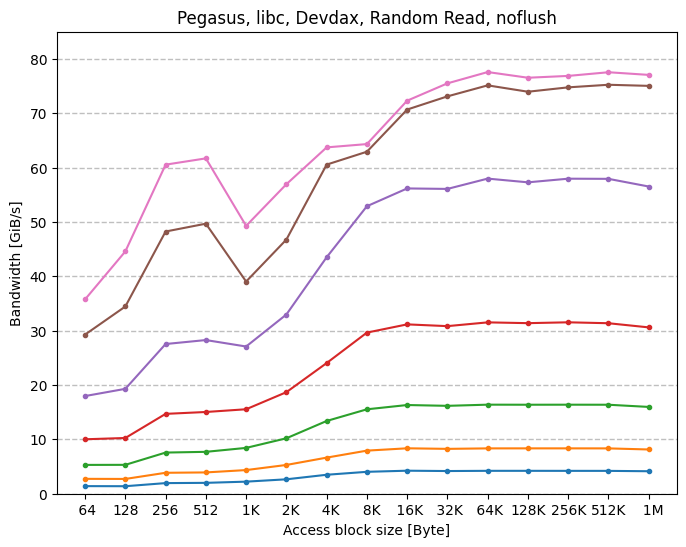

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'read', 'libc', 'sequential', False, True)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,3.693396,7.206588,13.743321,25.302432,44.652914,63.825217,70.357477
128,3.930329,7.677746,14.813192,27.562544,48.888493,69.072194,74.786831
256,4.162355,8.157287,15.788090,29.833823,54.731162,74.529428,77.349394
512,4.117635,8.070883,15.523008,28.934522,52.935749,73.413539,76.931841
1024,4.133399,8.127319,15.598716,29.051044,53.222521,74.244227,77.503988
2048,3.693046,7.219313,14.005179,26.650508,50.994089,70.789650,76.584481
4096,4.151411,7.806481,15.740884,28.778440,52.812844,73.608108,75.894449
8192,4.467424,8.796471,17.184624,32.619364,59.403127,76.399144,78.938156
16384,4.448746,8.775660,17.138003,32.568755,58.884540,75.304053,77.872658


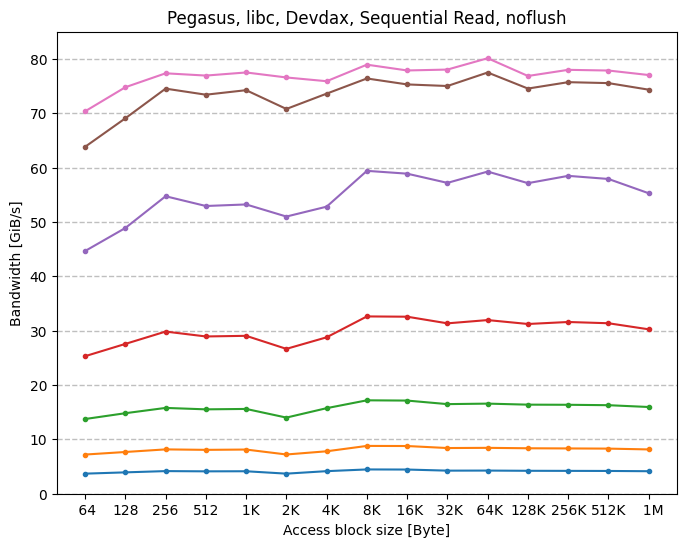

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'read', 'libpmem2', 'random', False, False)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.271158,0.555601,1.006628,1.990168,3.920858,7.489767,11.625454
128,0.463815,0.943267,1.627793,3.312500,6.533064,12.706520,18.702475
256,0.797660,1.578344,3.075084,5.482549,10.741712,20.718380,29.821726
512,1.095204,2.334063,4.077552,7.982940,15.433228,27.963088,39.514754
1024,1.415917,2.581515,5.190757,9.369323,17.783883,28.737432,38.016906
2048,2.075011,4.079684,7.812311,14.776735,26.297951,41.572572,48.913982
4096,2.406614,4.687677,8.962867,17.101739,30.786422,53.558402,58.919926
8192,2.370904,4.657421,9.048567,17.221173,31.069709,55.264076,64.979143
16384,2.414196,4.724853,9.168016,17.471478,31.463127,55.792661,64.058052


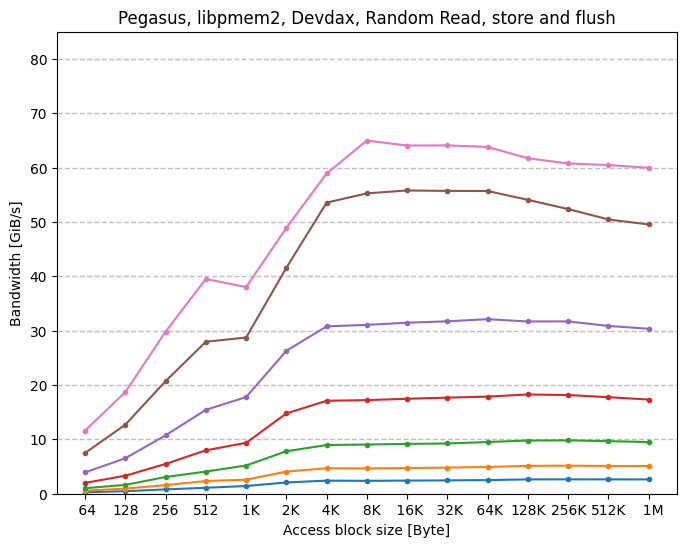

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'read', 'libpmem2', 'random', False, True)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.438557,0.865195,1.697199,3.288379,6.235083,11.339537,15.487617
128,0.875881,1.727792,3.398929,6.594172,12.605844,23.289149,32.379168
256,1.517614,2.987509,5.859949,11.283283,21.057935,36.757137,47.549576
512,1.955412,3.854556,7.512690,14.479741,26.838498,46.980316,59.064706
1024,2.549892,4.980793,9.546878,17.583871,30.253213,41.334248,56.373834
2048,3.164237,6.214467,11.981371,22.230496,39.070206,52.067208,64.413610
4096,3.812253,7.514054,14.668446,27.867142,50.215132,71.198367,75.736946
8192,3.993417,7.877908,15.385380,29.446950,53.533574,73.902211,77.540808
16384,4.140173,8.177031,15.949981,30.413833,55.038528,73.903897,77.510782


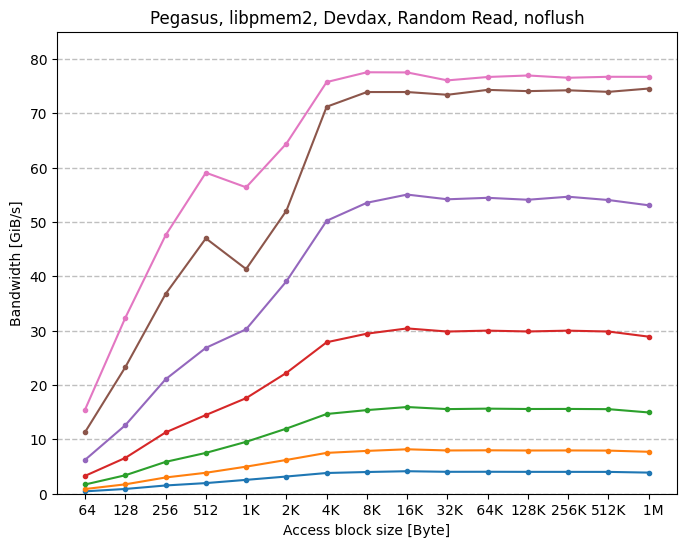

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'read', 'libpmem2', 'random', True, False)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.337341,0.638592,1.309684,2.504343,4.308364,8.599770,12.327185
128,0.684696,1.344511,2.213311,5.078766,9.657336,16.871876,24.558700
256,1.104318,2.206952,4.200121,8.188644,15.634173,28.466474,39.842912
512,1.592547,3.072822,5.869140,11.195786,20.330102,36.369785,49.083099
1024,1.853610,3.597249,6.922291,12.762862,22.350011,34.274638,46.680174
2048,2.447441,4.634159,8.888902,16.790936,30.299615,45.312781,55.781496
4096,2.994589,5.731218,10.912242,20.011281,35.124246,58.651001,65.685650
8192,3.264144,6.263002,11.963103,22.199166,38.618693,63.833723,68.333878
16384,3.389386,6.587542,12.551645,23.069933,40.222474,66.534839,70.501788


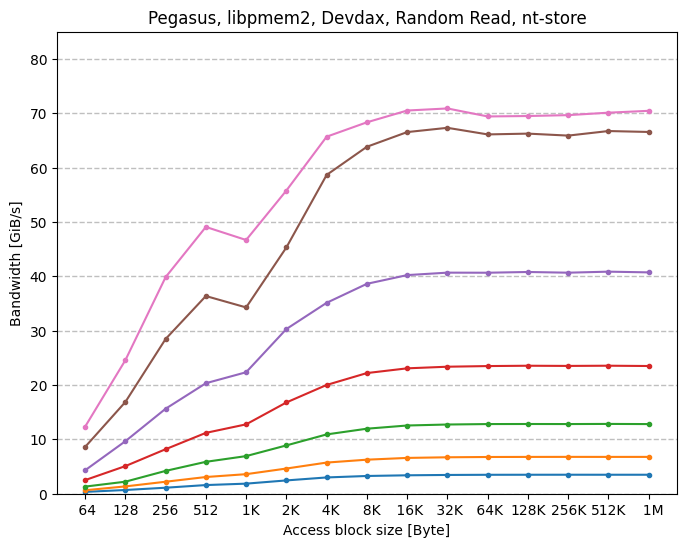

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'read', 'libpmem2', 'sequential', False, False)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.300076,0.590087,1.114852,2.062111,4.049890,7.706295,11.609886
128,0.514035,0.970052,1.810873,3.315294,6.226472,12.907496,18.706016
256,0.969524,1.574554,3.214039,5.855522,10.935009,20.840605,32.302279
512,1.354920,2.814154,4.669385,9.131340,18.074867,35.821610,52.249183
1024,2.192665,3.592556,7.485091,15.222115,27.998333,51.599775,62.252760
2048,2.392934,4.685301,9.126968,17.448124,31.793797,56.904068,62.795134
4096,2.434718,4.738889,9.090357,17.365172,31.732056,57.108057,64.434394
8192,2.441523,4.759259,9.254555,17.480575,31.632329,57.180232,64.568132
16384,2.449268,4.811933,9.295052,17.616320,31.946133,55.718144,64.381137


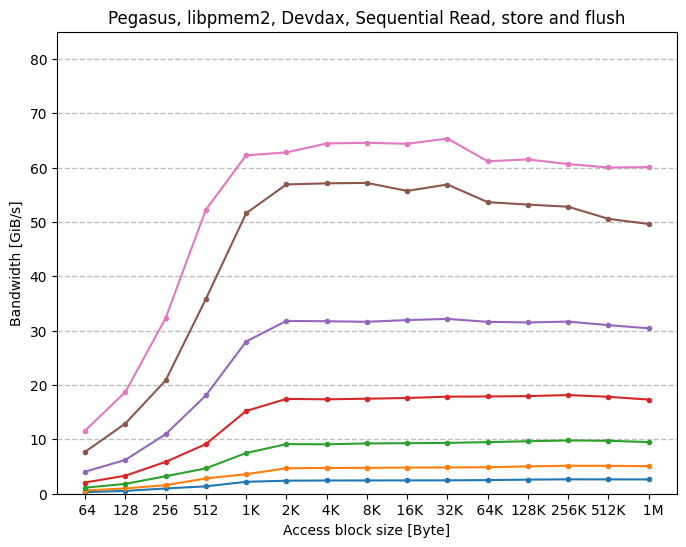

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'read', 'libpmem2', 'sequential', False, True)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,2.663216,5.200079,10.047007,18.920600,33.965156,56.694047,65.365241
128,3.283982,6.443203,12.468918,23.344488,41.297451,62.281256,68.421875
256,3.761466,7.103906,13.842863,26.437057,47.651068,68.795872,75.459507
512,3.939441,7.689668,14.805162,27.530007,48.956193,70.330961,74.843492
1024,4.208481,8.234457,15.896425,29.979512,54.729252,74.656630,77.687225
2048,4.258551,8.370339,16.273444,30.784622,56.128192,75.242076,77.306367
4096,4.279835,8.429337,16.447311,31.245326,56.819275,75.561346,78.111622
8192,4.315400,8.508245,16.630036,31.896044,57.979330,77.609524,80.309346
16384,4.312733,8.504583,16.621873,31.788791,57.640096,75.374177,78.924996


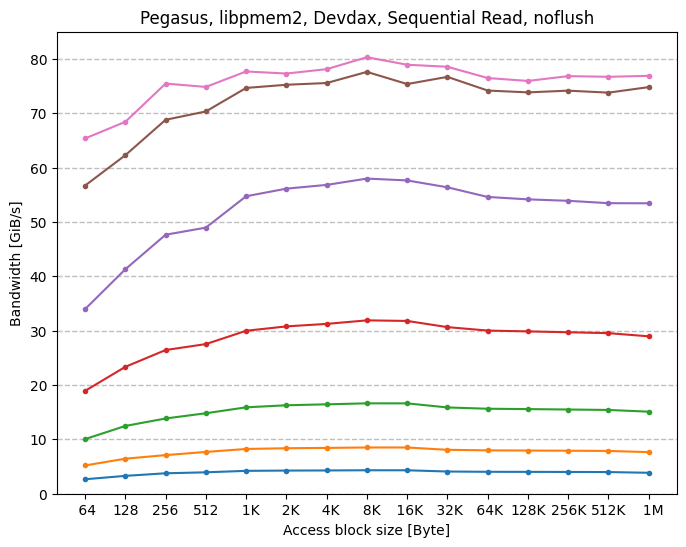

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'read', 'libpmem2', 'sequential', True, False)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.357209,0.671559,1.369936,2.720137,4.883970,8.895718,13.584267
128,0.731246,1.370331,2.733880,5.407267,9.289024,17.623272,26.157256
256,1.406903,2.730161,5.324021,9.799508,17.339696,35.182986,51.245036
512,2.541938,4.796477,8.855535,17.774572,32.820407,60.090544,66.079993
1024,3.421421,6.341481,12.207571,22.420973,40.274194,62.891618,65.618446
2048,3.377580,6.587555,12.336432,23.015736,40.935559,63.499587,66.117912
4096,3.201190,6.065067,11.526988,20.964277,36.727791,63.142092,68.776776
8192,3.435508,6.623158,12.588954,23.053191,40.184502,66.550788,70.167310
16384,3.485987,6.804548,12.833893,23.593281,40.790150,66.124682,69.451111


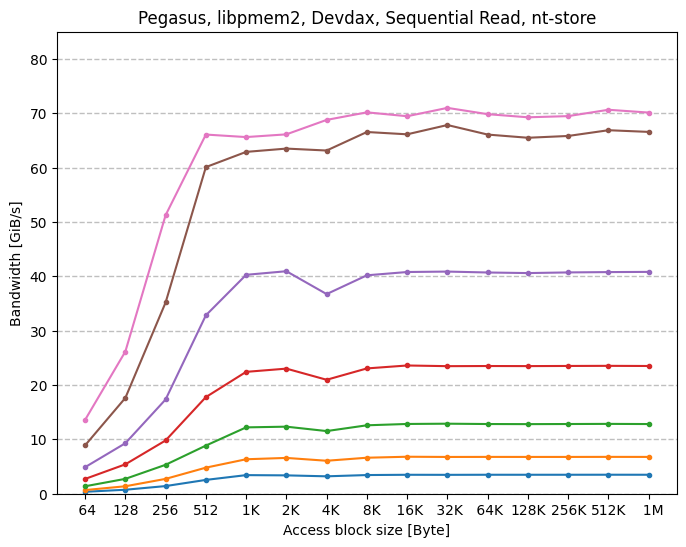

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'write', 'libpmem2', 'random', False, False)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.081693,0.162381,0.322125,0.635428,1.239727,2.370340,3.419241
128,0.156827,0.311669,0.617685,1.216321,2.365596,4.505560,6.468537
256,0.285814,0.567420,1.121072,2.189695,4.169990,7.529941,10.171688
512,0.534668,1.047096,2.020266,3.794491,6.821017,11.271509,13.979376
1024,1.161984,2.225711,4.148972,7.311358,11.583548,14.114037,15.575273
2048,1.563264,2.964282,5.391093,9.269184,13.430530,16.469708,17.118858
4096,2.143852,4.044428,7.207313,11.860156,16.315583,18.631485,18.809841
8192,2.429977,4.547032,8.080523,12.903935,16.839267,18.777428,23.582596
16384,2.588590,4.840333,8.600577,13.329059,17.178457,22.139263,23.588631


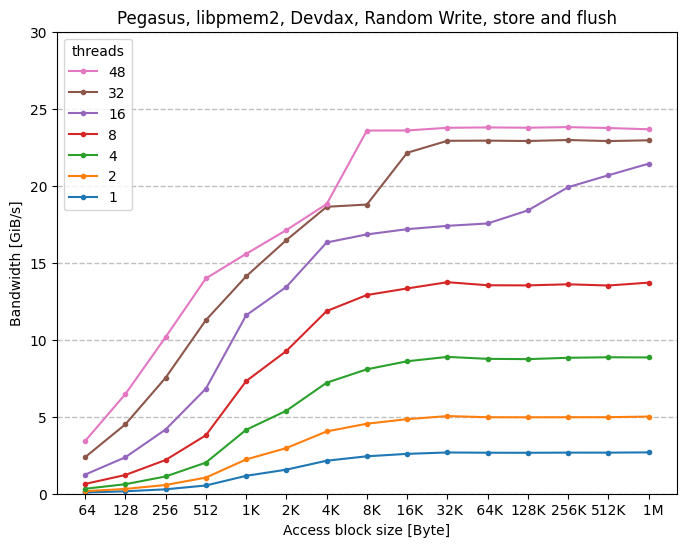

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'write', 'libpmem2', 'random', True, False)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.246502,0.492651,0.983885,1.962019,3.903833,7.708543,11.270049
128,0.486048,0.970823,1.937094,3.854758,7.598558,14.131613,18.749892
256,0.966864,1.928829,3.829884,7.465065,13.531010,20.429527,22.971971
512,1.826040,3.632134,7.095863,12.870419,19.673274,23.684120,24.186692
1024,3.369078,6.638656,12.220587,19.304511,23.922655,24.528070,24.448580
2048,5.729262,11.008992,18.433188,24.138389,24.703649,24.623387,24.532481
4096,8.546462,15.645604,23.584867,24.656087,24.572364,24.435264,24.099324
8192,11.429461,19.226140,24.325274,24.566085,24.443418,23.830849,23.374259
16384,13.714773,22.098433,24.773886,24.667844,24.141323,23.404005,23.219732


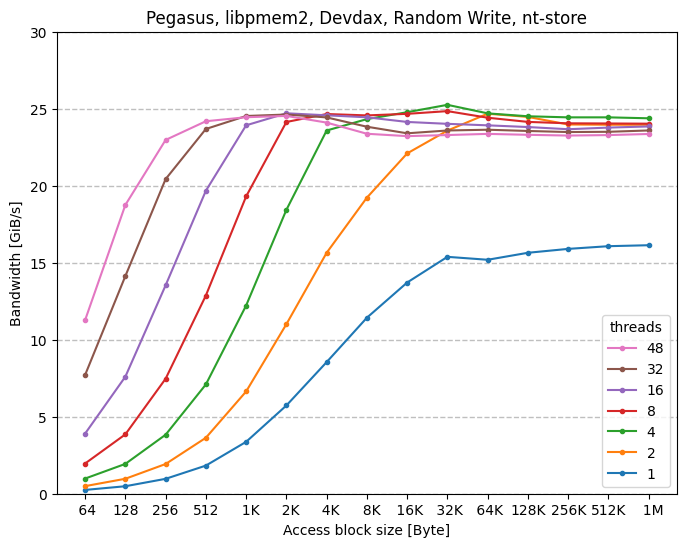

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'write', 'libpmem2', 'sequential', False, False)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.222994,0.445175,0.887676,1.767219,3.505443,6.872426,10.061136
128,0.427488,0.852891,1.692879,3.343891,6.511545,11.749446,15.874980
256,0.791666,1.569310,3.089566,5.844782,10.378204,15.916275,18.299193
512,1.237901,2.381241,4.431185,7.847027,12.721426,17.156261,18.871370
1024,1.757843,3.407862,6.390498,11.073486,16.368203,19.027318,19.215574
2048,1.995051,3.806875,6.959586,11.518120,15.971601,18.915701,19.243736
4096,2.201060,4.160858,7.476563,12.205323,16.634650,19.061355,19.437389
8192,2.431837,4.609979,8.232843,12.988793,16.948456,19.106103,23.534527
16384,2.568479,4.858348,8.617523,13.420419,17.257270,22.347605,23.662230


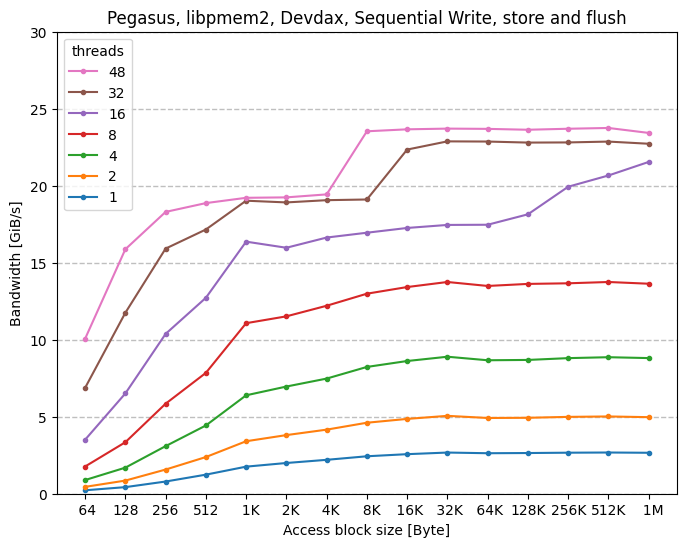

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'write', 'libpmem2', 'sequential', True, False)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.246692,0.493067,0.985045,1.965150,3.911588,7.732650,11.386552
128,0.487091,0.972502,1.939224,3.859314,7.655204,14.660224,20.532863
256,0.967658,1.932799,3.857231,7.672475,14.739505,24.094131,25.216563
512,1.824621,3.643500,7.234968,13.861603,23.204927,25.415045,24.989226
1024,3.354788,6.662250,12.770977,22.721656,25.836094,25.099447,24.648649
2048,5.745192,11.188351,20.487267,25.686861,25.421482,24.801391,24.571550
4096,8.582763,15.954092,24.723927,25.786644,25.177816,24.689140,24.204667
8192,11.507166,19.705706,25.177555,25.565717,25.028022,24.060040,23.471498
16384,13.747320,22.422960,25.335828,25.354389,24.492856,23.549117,23.343302


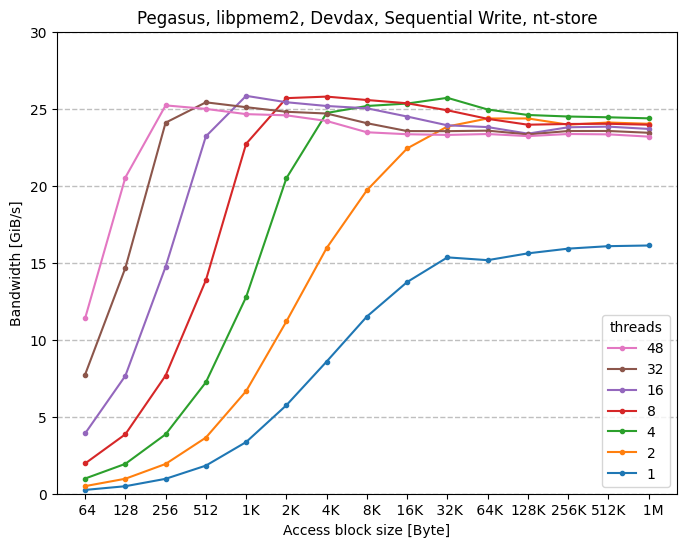

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
df = grouper.max().reset_index()

ymax = df.groupby(["accessType"]).max()["byte_per_sec"].apply(lambda x: x / 2**30).apply(lambda x: x + -x % 5).astype('int').to_dict()

for idx, df_sub in df.query("platform == 'pegasus' and source == 'devdax'").groupby(["platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush"]):
    print(idx)
    platform, source, access_type, api, access_pattern, is_nt, is_noflush = idx
    # display(df_sub)
    df_sub["GiB/s"] = df_sub["byte_per_sec"] / 2**30
    df_plot = df_sub.pivot(index="blockSize", columns="nthreads", values="GiB/s")
    display(df_plot)

    fig = plt.figure(figsize=(8,6), dpi=100)
    fig.patch.set_alpha(1)

    ax = df_plot.plot(
        ax=fig.add_subplot(),
        xlabel="Access block size [Byte]",
        ylabel="Bandwidth [GiB/s]",
        ylim=[0, ymax[access_type]],
        style=".-",
        legend=access_type == "write",
    )
    if is_nt:
        store_type = ", nt-store"
    elif is_noflush:
        store_type = ", noflush"
    else:
        store_type = ", store and flush"

    ax.set_title(f"{platform.capitalize()}, {api}, {source.capitalize()}, {access_pattern.capitalize()} {access_type.capitalize()}{store_type}")
    ax.set_xscale("log", base=2)
    ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
    ax.grid(which = "major", axis = "y", alpha = 0.8,
        linestyle = "--", linewidth = 1)

    if idx[2] == "write":
        handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
        ax.legend(title='threads', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
        # ax.legend(handles=handles[::-1],labels=list(map(lambda x: f"{x} proc{'s' if int(x) > 1 else ''}", labels[::-1])))# 判例を逆順に表示
    
    fig.show()
    plt.show()
    ax.set_title("")
    save(fig, f"pmembench-{platform}-{api}-{source}-{access_type}-{access_pattern}{'-movnt' if is_nt else ''}{'-noflush' if is_noflush else ''}")

In [7]:
# pegasus upto 16 threads
df = df_src.query("platform == 'pegasus' and nthreads<=16").drop(["path", "granularity", "set-affinity", "addr", "success"], axis=1)

max_throuput_groupby = ["platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush", "blockSize"]
pegasus16_grouper = df.groupby(max_throuput_groupby)
df_pegasus16_max = df.loc[pegasus16_grouper["byte_per_sec"].idxmax()]

df_pegasus16_max.platform = "pegasus16"

df_pegasus16_max.query("accessType == 'write' and blockSize==64")


,noflush,accessPattern,accessType,blockSize,nonTemporal,nthreads,source,stripeSize,totalSize,iter,platform,loadApi,device,api,IOPS,MIOPS,MiB_per_sec,byte_per_sec,time
2140,False,random,write,64,False,8,anon,68719476736,68719476736,2,pegasus16,libc,Optane 300,libpmem2,8.752398e+07,87.523983,5342.039993,5.601535e+09,12267.972552
2085,False,random,write,64,True,8,anon,68719476736,68719476736,3,pegasus16,libc,Optane 300,libpmem2,4.373886e+07,43.738865,2669.608456,2.799287e+09,24548.918347
1723,False,sequential,write,64,False,8,anon,68719476736,68719476736,2,pegasus16,libc,Optane 300,libpmem2,1.153510e+08,115.350952,7040.463368,7.382461e+09,9308.478232
2538,False,sequential,write,64,True,8,anon,68719476736,68719476736,3,pegasus16,libc,Optane 300,libpmem2,3.383153e+07,33.831528,2064.912620,2.165218e+09,31737.904718
16493,False,random,write,64,False,16,devdax,137438953472,137438953472,2,pegasus16,libpmem2,Optane 300,libpmem2,2.079918e+07,20.799175,1269.480914,1.331147e+09,103248.499904
15546,False,random,write,64,True,16,devdax,137438953472,137438953472,2,pegasus16,libpmem2,Optane 300,libpmem2,6.549545e+07,65.495450,3997.525005,4.191709e+09,32788.287708
14514,False,sequential,write,64,False,16,devdax,137438953472,137438953472,1,pegasus16,libpmem2,Optane 300,libpmem2,5.881157e+07,58.811573,3589.573576,3.763941e+09,36514.643656
13329,False,sequential,write,64,True,16,devdax,137438953472,137438953472,2,pegasus16,libpmem2,Optane 300,libpmem2,6.562556e+07,65.625558,4005.466194,4.200036e+09,32723.282049
4405,False,random,write,64,False,16,fsdax,137438953472,137438953472,3,pegasus16,libc,Optane 300,libpmem2,2.076186e+07,20.761857,1267.203216,1.328759e+09,103434.080932
4155,False,random,write,64,True,16,fsdax,137438953472,137438953472,2,pegasus16,libc,Optane 300,libpmem2,6.545542e+07,65.455424,3995.082040,4.189147e+09,32808.337524


In [8]:
# df_src.groupby(["platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush"]).size()

In [9]:
df = df_src.query("success == True").drop(["path", "granularity", "set-affinity", "addr", "success", "loadApi"], axis=1)
df = df.query("platform != 'cygnus' and source == 'devdax' and ((accessType == 'write' and nonTemporal == True) or (accessType == 'read' and noflush == True))")

# max throuput
max_throuput_grouper = df.groupby(max_throuput_groupby)

pd.set_option('display.max_rows', 50)
df_max = df.loc[max_throuput_grouper["byte_per_sec"].idxmax()]

# df_max = pd.concat([df_max, df_pegasus16_max])

df_max["GiB/s"] = df_max["byte_per_sec"] / 2**30

# for idx, dfsub in max_throuput_grouper:
#     print(idx)

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# for idx, df_sub in df_max.groupby(["device", "accessType", "accessPattern", "api"]):
#     print(idx)
#     display(df_sub)
df_max.groupby(["device", "accessType", "accessPattern", "api"]).size()
# max_throuput_grouper.size()

# df_max.query("platform == 'chris80' and accessType == 'read' and accessPattern == 'random' and api == 'libpmem2'")

device      accessType  accessPattern  api     
Optane 100  read        random         libc        15
                                       libpmem2    15
                        sequential     libc        15
                                       libpmem2    15
            write       random         libpmem2    15
                        sequential     libpmem2    15
Optane 200  read        random         libc        15
                                       libpmem2    15
                        sequential     libc        15
                                       libpmem2    15
            write       random         libpmem2    15
                        sequential     libpmem2    15
Optane 300  read        random         libc        15
                                       libpmem2    15
                        sequential     libc        15
                                       libpmem2    15
            write       random         libpmem2    15
                        sequential

{'read': 90, 'write': 30}


,Optane 100 random,Optane 100 sequential,Optane 200 random,Optane 200 sequential,Optane 300 random (libc),Optane 300 random,Optane 300 sequential
blockSize,,,,,,,
64,3.860507,28.795378,4.945427,26.980171,35.759426,15.487617,65.365241
128,7.209307,31.608222,9.183886,28.322333,44.581031,32.379168,68.421875
256,13.160624,33.207738,16.398986,26.444562,60.542520,47.549576,75.459507
512,19.313919,32.068962,16.503700,27.609569,61.697388,59.064706,74.843492
1024,14.248476,33.464826,23.418277,36.205377,49.283609,56.373834,77.687225
2048,20.029879,35.389036,26.233363,35.613260,56.942540,64.413610,77.306367
4096,25.731961,34.782895,29.938739,26.908168,63.720457,75.736946,78.111622
8192,27.282681,35.218710,29.180483,34.992700,64.327501,77.540808,80.309346
16384,28.114478,34.803250,32.311608,38.571662,72.312425,77.510782,78.924996


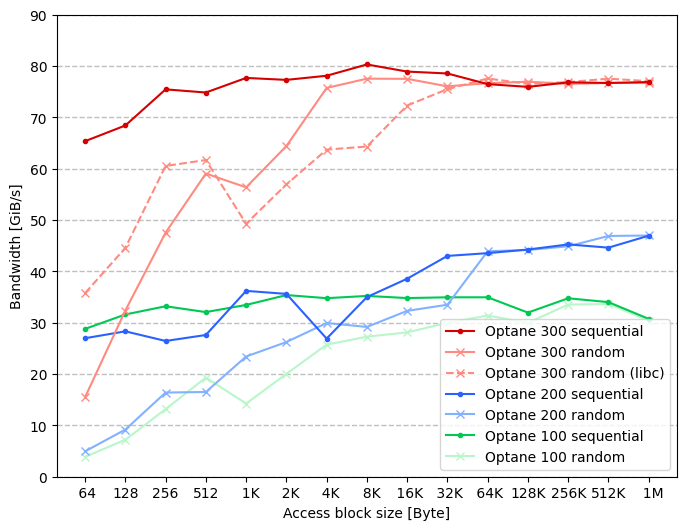

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


,Optane 100 random,Optane 100 sequential,Optane 200 random,Optane 200 sequential,Optane 300 random,Optane 300 sequential
blockSize,,,,,,
64,2.594522,8.344457,3.821872,9.815379,11.270049,11.386552
128,4.987624,10.371421,7.445287,14.722460,18.749892,20.532863
256,10.024866,11.333293,14.011531,14.986178,22.971971,25.216563
512,9.977394,11.403345,13.437177,13.892558,24.186692,25.415045
1024,9.702792,11.507365,12.443069,13.173816,24.528070,25.836094
2048,9.463000,11.550899,11.473061,12.347820,24.703649,25.686861
4096,8.833155,11.514266,9.819301,11.622869,24.656087,25.786644
8192,9.657913,11.542425,10.176946,12.502830,24.566085,25.565717
16384,10.191523,11.545418,11.313746,13.121214,24.773886,25.354389


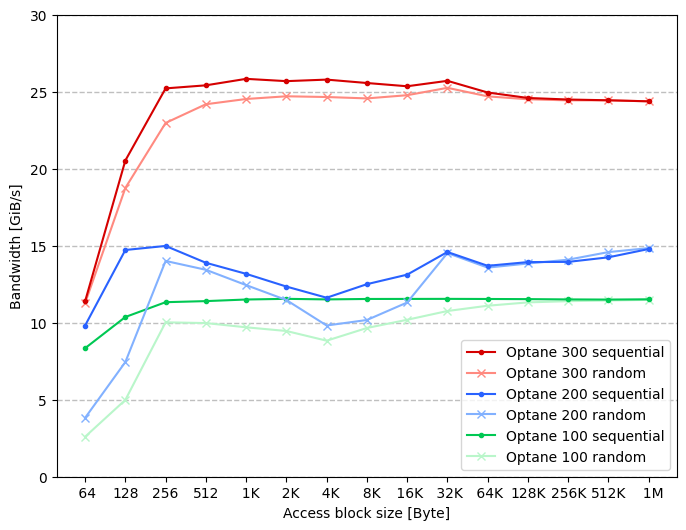

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [11]:
df = df_max

ymax = df.groupby(["accessType"]).max()["byte_per_sec"].apply(lambda x: x / 2**30).apply(lambda x: x + -x % 5).astype('int').to_dict()
ymax["read"] = 90
print(ymax)

platform_list = ["chris80", "chris90", "pegasus"]
# blocksize_list = [64, 256, 4*1024, 128*1024]
blocksize_list = [2**x for x in range(6, 21)]

df = df.loc[df.blockSize.isin(blocksize_list)]

color = {
    "read": [
        "#B9F6CA",
        "#00C853",
        "#82b1ff",
        "#2962ff",
        "#ff8a80", 
        "#ff8a80", 
        "#d50000",
    ],
    "write": [
        "#B9F6CA",
        "#00C853",
        "#82b1ff",
        "#2962ff",
        "#ff8a80", 
        "#d50000",
    ]
}

style = {
    "read": [ "x-", ".-", "x-", ".-", "x--", "x-", ".-" ],
    "write": [ "x-", ".-", "x-", ".-", "x-", ".-" ],
}

for accessType in ["read", "write"]:
    df_plot = pd.concat([
        df_sub.set_index("blockSize")["GiB/s"].rename(f"{idx[0]} {idx[1]}{' (libc)' if idx[2] == 'libc' else ''}")
        for platform in platform_list
        for idx, df_sub in df[(df.accessType == accessType) & (df.platform == platform)].groupby(["device", "accessPattern", "api"])
        if idx[2] == 'libpmem2' or (idx[2] == 'libc' and platform == 'pegasus' and idx[1] == 'random')
    ], axis=1)

    # df_plot.index = df_plot.index.map(lambda x: pretty_fmt(x, suffix=""))

    display(df_plot)

    fig = plt.figure(figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(1)

    ax = df_plot.plot(
        # kind="bar",
        ax=fig.add_subplot(),
        rot=0,
        xlabel="Access block size [Byte]",
        ylabel="Bandwidth [GiB/s]",
        ylim=[0, ymax[accessType]],
        style=style[accessType],
        color=color[accessType],
    )
    
    # ax.set_title(f"Devdax {accessType.capitalize()} {'( nt-store )' if accessType == 'write' else ''}")
    ax.set_xscale("log", base=2)
    ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
    ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)

    handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
    ax.legend(handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示

    fig.show()
    plt.show()
    save(fig, f"pmembench-comp-devdax-{accessType}")